In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 加载数据
csv_file_path = 'snr_data/output_data_snr_6.csv'
data_frame = pd.read_csv(csv_file_path)

# 提取前256列数据并转换为张量
vectors = torch.tensor(data_frame.iloc[:, :256].values, dtype=torch.float32)

# 划分训练集和测试集索引
train_size = int(0.8 * len(vectors))
test_size = len(vectors) - train_size
train_indices, test_indices = random_split(range(len(vectors)), [train_size, test_size])

# 使用训练集的统计量进行归一化
train_vectors = vectors[train_indices]
train_mean = train_vectors.mean(dim=0, keepdim=True)
train_std = train_vectors.std(dim=0, keepdim=True)

vectors = (vectors - train_mean) / train_std

# 转置和重塑为16x16
vectors = vectors.view(-1, 16, 16).unsqueeze(1).permute(0, 1, 3, 2)  # 添加通道维度并进行转置

# 提取Mod_Type列并转换为数值标签
mod_types = data_frame['Mod_Type'].astype('category').cat.codes.values
labels = torch.tensor(mod_types, dtype=torch.long)

# 创建TensorDataset
dataset = TensorDataset(vectors, labels)

# 创建训练集和测试集
train_dataset = TensorDataset(vectors[train_indices], labels[train_indices])
test_dataset = TensorDataset(vectors[test_indices], labels[test_indices])

# 创建DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [2]:
# 定义ResNet基本块
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

# 定义ResNet
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=11):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.linear = nn.Linear(32*4*4*4, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2])

model = ResNet18()


In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:
num_epochs = 100
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # 测试阶段
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

print("Training complete.")


Epoch [1/100], Train Loss: 1.2968, Train Accuracy: 0.5023, Test Loss: 1.2621, Test Accuracy: 0.5686
Epoch [2/100], Train Loss: 0.8968, Train Accuracy: 0.6332, Test Loss: 0.8558, Test Accuracy: 0.6600
Epoch [3/100], Train Loss: 0.7475, Train Accuracy: 0.6832, Test Loss: 0.7816, Test Accuracy: 0.6505
Epoch [4/100], Train Loss: 0.6067, Train Accuracy: 0.7374, Test Loss: 0.6499, Test Accuracy: 0.6964
Epoch [5/100], Train Loss: 0.5113, Train Accuracy: 0.7764, Test Loss: 0.9395, Test Accuracy: 0.6523
Epoch [6/100], Train Loss: 0.4183, Train Accuracy: 0.8083, Test Loss: 0.5766, Test Accuracy: 0.7536
Epoch [7/100], Train Loss: 0.3758, Train Accuracy: 0.8357, Test Loss: 0.6635, Test Accuracy: 0.7291
Epoch [8/100], Train Loss: 0.3116, Train Accuracy: 0.8595, Test Loss: 0.5906, Test Accuracy: 0.7695
Epoch [9/100], Train Loss: 0.2949, Train Accuracy: 0.8706, Test Loss: 0.5908, Test Accuracy: 0.7664
Epoch [10/100], Train Loss: 0.2568, Train Accuracy: 0.8866, Test Loss: 0.6739, Test Accuracy: 0.7491

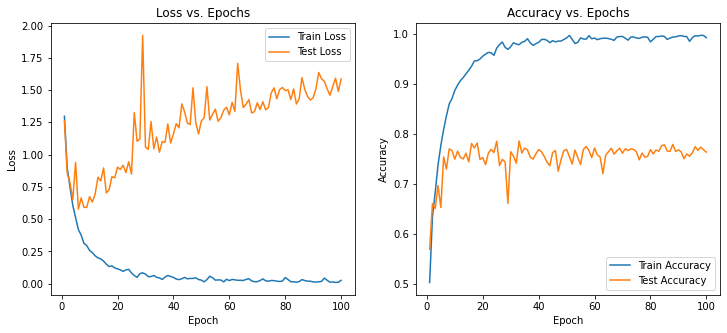

In [5]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# 绘制损失图像
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

# 绘制准确率图像
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.show()


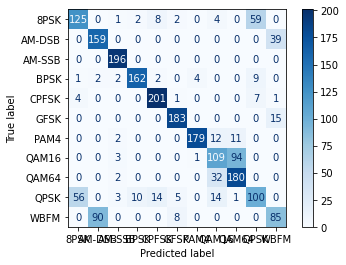

In [6]:
# 计算混淆矩阵
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

# 绘制混淆矩阵
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_frame['Mod_Type'].astype('category').cat.categories)
disp.plot(cmap=plt.cm.Blues)
plt.show()
